# Models plots

In [2]:
import sys
from pathlib import Path

import os
from pathlib import Path
NOTEBOOK_DIR = Path(os.getcwd())
ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from src.utils.config_resolver import load_config
from src.data.load_data import load_flights          # or loader.py if you named it that way
from src.data.train_test_split import train_test_split_flight
from src.features.add_features import add_features
from src.features.soc_estimation import compute_soc
from src.features.add_is_flying import add_is_flying
import joblib
from src.utils.path_resolver import MODELS_DIR


# MLR

In [4]:
df = load_flights()
df = add_features(df)
df = compute_soc(df)   # adds dt_sec, mAh_used, soc_coulomb_mAh

# 2. Train/test split by flight (same logic as training)
cfg = load_config("mlr.yaml")
split = cfg["train_split"]
features = cfg["features"]

train_df, test_df = train_test_split_flight(df, split_ratio=split)

In [5]:
model_path = MODELS_DIR / "mlr_battery_current.pkl"
mlr_model = joblib.load(model_path)

X_test = test_df[features].fillna(0.0)
test_df = test_df.copy()
test_df["battery_current_pred"] = mlr_model.predict(X_test)

test_ids = test_df["flight"].unique()
flight_to_plot = np.random.choice(test_ids)

C:\Users\muric\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


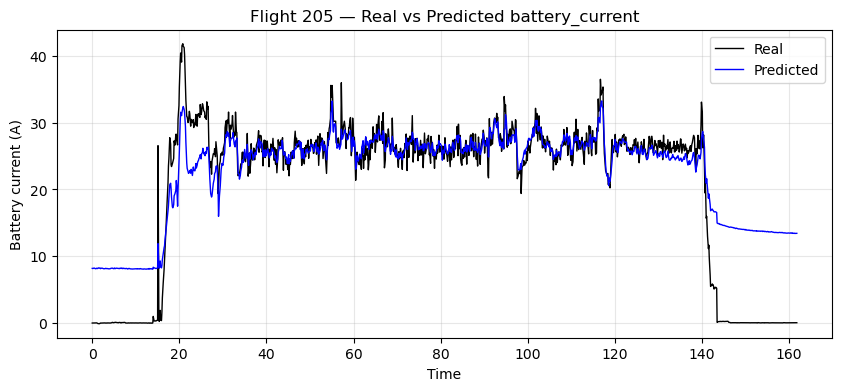

In [6]:
plot_data = (
    test_df[test_df["flight"] == flight_to_plot]
    .sort_values("time")
    .copy()
)

plt.figure(figsize=(10, 4))
plt.plot(plot_data["time"], plot_data["battery_current"], label="Real", linewidth=1, color="black")
plt.plot(plot_data["time"], plot_data["battery_current_pred"], label="Predicted", linewidth=1, color="blue")
plt.title(f"Flight {flight_to_plot} — Real vs Predicted battery_current")
plt.xlabel("Time")
plt.ylabel("Battery current (A)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


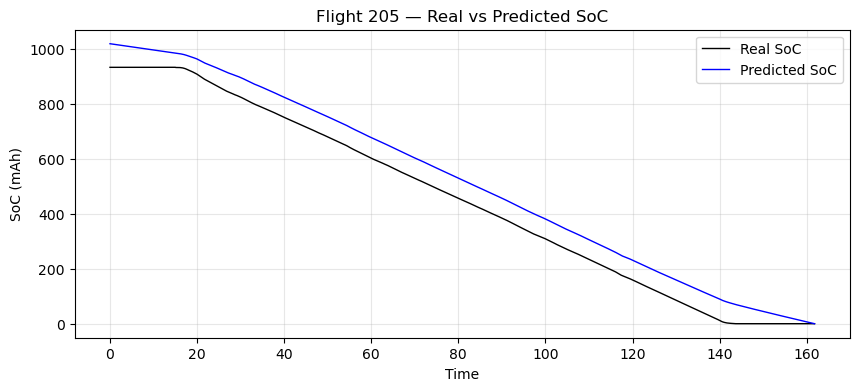

In [7]:
plot_data = plot_data.copy()

# ensure dt_sec for this flight only (numeric time)
# if time is already numeric (seconds) this is fine
plot_data["dt_sec"] = plot_data["time"].diff().fillna(0.0)

# Real current → SoC
plot_data["mAh_used"] = (plot_data["dt_sec"] / 3600.0) * (plot_data["battery_current"] * 1000)
plot_data["cum_mAh_used"] = plot_data["mAh_used"].cumsum()
plot_data["total_mAh_used"] = plot_data["cum_mAh_used"].max()
plot_data["soc_coulomb_mAh"] = plot_data["total_mAh_used"] - plot_data["cum_mAh_used"]

# Predicted current → SoC_pred
plot_data["mAh_used_pred"] = (plot_data["dt_sec"] / 3600.0) * (plot_data["battery_current_pred"] * 1000)
plot_data["cum_mAh_used_pred"] = plot_data["mAh_used_pred"].cumsum()
plot_data["total_mAh_used_pred"] = plot_data["cum_mAh_used_pred"].max()
plot_data["soc_coulomb_mAh_pred"] = plot_data["total_mAh_used_pred"] - plot_data["cum_mAh_used_pred"]

plt.figure(figsize=(10, 4))
plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh"], label="Real SoC", linewidth=1, color="black")
plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh_pred"], label="Predicted SoC", linewidth=1, color="blue")
plt.title(f"Flight {flight_to_plot} — Real vs Predicted SoC")
plt.xlabel("Time")
plt.ylabel("SoC (mAh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# XGBoost

In [9]:
df = load_flights()
df = add_features(df)
df = compute_soc(df)   # adds dt_sec, mAh_used, soc_coulomb_mAh
df = add_is_flying(df)

# 2. Train/test split by flight (same logic as training)
cfg = load_config("XGB.yaml")
split = cfg["train_split"]
features = cfg["features"]

train_df, test_df = train_test_split_flight(df, split_ratio=split)

In [10]:
model_path = MODELS_DIR / "xgb_battery_current.pkl"
xgb_model = joblib.load(model_path)

X_test = test_df[features].fillna(0.0)
test_df = test_df.copy()

test_df["battery_current_pred"] = xgb_model.predict(X_test)

test_ids = test_df["flight"].unique()
flight_to_plot = np.random.choice(test_ids)

C:\Users\muric\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:12:39] WARNING: D:\bld\xgboost-split_1737531311373\work\src\gbm\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


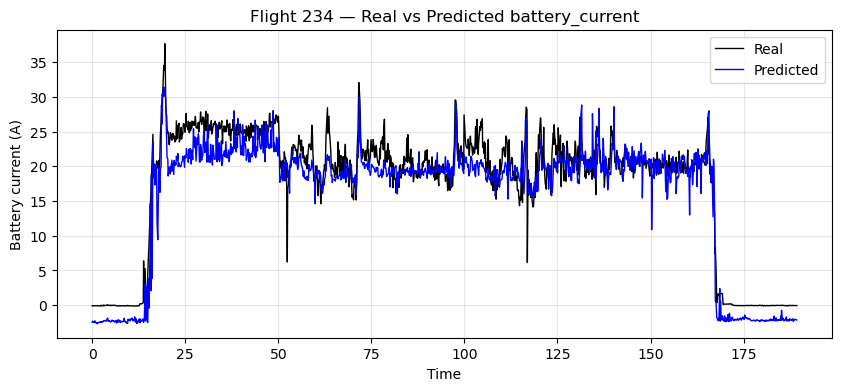

In [11]:
plot_data = (
    test_df[test_df["flight"] == flight_to_plot]
    .sort_values("time")
    .copy()
)

plt.figure(figsize=(10, 4))
plt.plot(plot_data["time"], plot_data["battery_current"], label="Real", linewidth=1, color="black")
plt.plot(plot_data["time"], plot_data["battery_current_pred"], label="Predicted", linewidth=1, color="blue")
plt.title(f"Flight {flight_to_plot} — Real vs Predicted battery_current")
plt.xlabel("Time")
plt.ylabel("Battery current (A)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

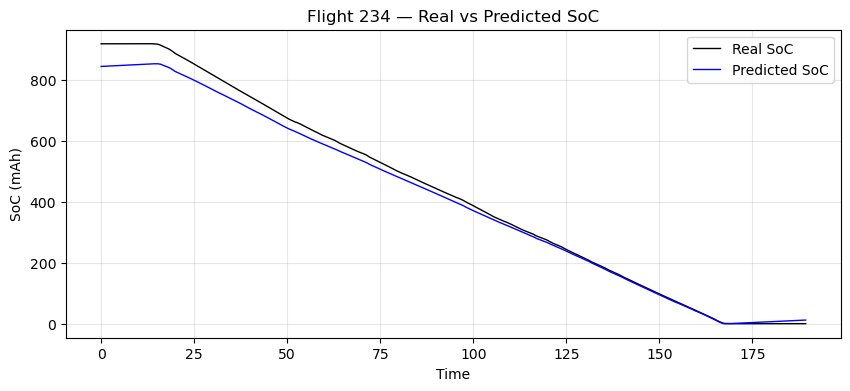

In [12]:
plot_data = plot_data.copy()

# ensure dt_sec for this flight only (numeric time)
# if time is already numeric (seconds) this is fine
plot_data["dt_sec"] = plot_data["time"].diff().fillna(0.0)

# Real current → SoC
plot_data["mAh_used"] = (plot_data["dt_sec"] / 3600.0) * (plot_data["battery_current"] * 1000)
plot_data["cum_mAh_used"] = plot_data["mAh_used"].cumsum()
plot_data["total_mAh_used"] = plot_data["cum_mAh_used"].max()
plot_data["soc_coulomb_mAh"] = plot_data["total_mAh_used"] - plot_data["cum_mAh_used"]

# Predicted current → SoC_pred
plot_data["mAh_used_pred"] = (plot_data["dt_sec"] / 3600.0) * (plot_data["battery_current_pred"] * 1000)
plot_data["cum_mAh_used_pred"] = plot_data["mAh_used_pred"].cumsum()
plot_data["total_mAh_used_pred"] = plot_data["cum_mAh_used_pred"].max()
plot_data["soc_coulomb_mAh_pred"] = plot_data["total_mAh_used_pred"] - plot_data["cum_mAh_used_pred"]

plt.figure(figsize=(10, 4))
plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh"], label="Real SoC", linewidth=1, color="black")
plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh_pred"], label="Predicted SoC", linewidth=1, color="blue")
plt.title(f"Flight {flight_to_plot} — Real vs Predicted SoC")
plt.xlabel("Time")
plt.ylabel("SoC (mAh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
test_df[test_df.time > 100]

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,d_position_y,d_position_z,d_position_h,dt_sec,mAh_used,cum_mAh_used,total_mAh_used,soc_coulomb_mAh,is_flying,battery_current_pred
3816,3,100.20,10.2,237.0,22.022320,18.949078,-79.781924,40.458715,289.877870,-0.004057,...,-0.548811,0.011148,1.210649,0.20,1.052727,573.506828,789.073853,215.567024,1,18.778950
3817,3,100.30,10.2,238.0,22.031084,18.790041,-79.781927,40.458710,289.872681,-0.007772,...,-0.268877,-0.005190,0.592853,0.10,0.521946,574.028774,789.073853,215.045079,1,19.145096
3818,3,100.50,10.3,239.0,21.874578,21.175573,-79.781934,40.458701,289.873224,-0.009963,...,-0.544736,0.000544,1.210906,0.20,1.176421,575.205195,789.073853,213.868658,1,18.013575
3819,3,100.60,10.3,239.0,21.806967,21.899185,-79.781937,40.458696,289.881666,-0.010632,...,-0.271178,0.008442,0.605960,0.10,0.608311,575.813505,789.073853,213.260347,1,18.253635
3820,3,100.81,10.4,239.0,21.756886,22.241112,-79.781943,40.458686,289.858074,-0.012813,...,-0.536421,-0.023592,1.179421,0.21,1.297398,577.110903,789.073853,211.962949,1,18.264656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256903,278,185.79,1.5,133.0,23.429625,0.127228,-79.782787,40.459031,269.882845,-0.018005,...,-0.011488,0.028593,0.015182,0.20,0.007068,887.178621,887.198699,0.020078,0,-2.159538
256904,278,186.00,1.5,131.0,23.440893,0.119277,-79.782787,40.459031,269.886999,-0.018017,...,0.001936,0.004154,0.003144,0.21,0.006958,887.185579,887.198699,0.013120,0,-2.273732
256905,278,186.10,1.5,132.0,23.432129,0.111325,-79.782787,40.459031,269.916411,-0.018028,...,-0.009906,0.029412,0.016737,0.10,0.003092,887.188671,887.198699,0.010028,0,-2.263386
256906,278,186.20,1.5,131.0,23.433380,0.119277,-79.782787,40.459031,269.942487,-0.018005,...,-0.012215,0.026076,0.018131,0.10,0.003313,887.191984,887.198699,0.006715,0,-2.257448
